# 회귀 계수 추가

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


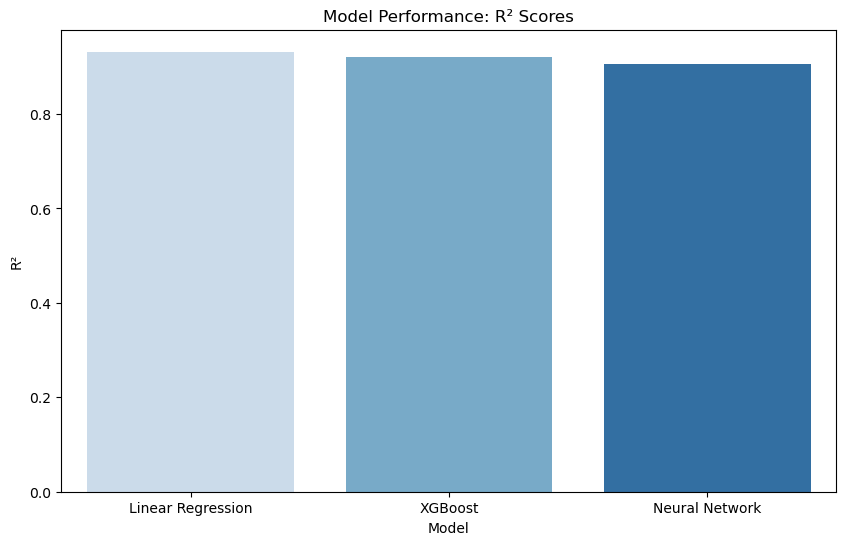

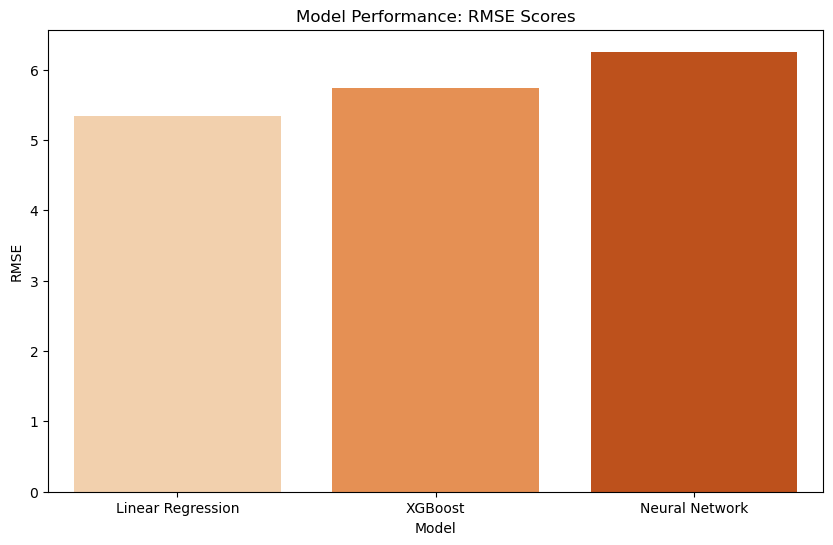

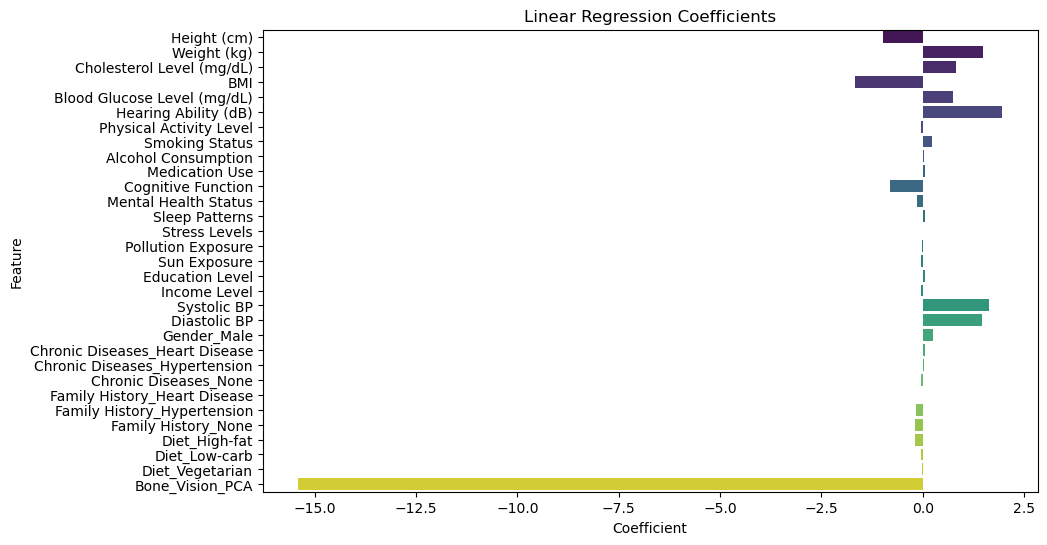

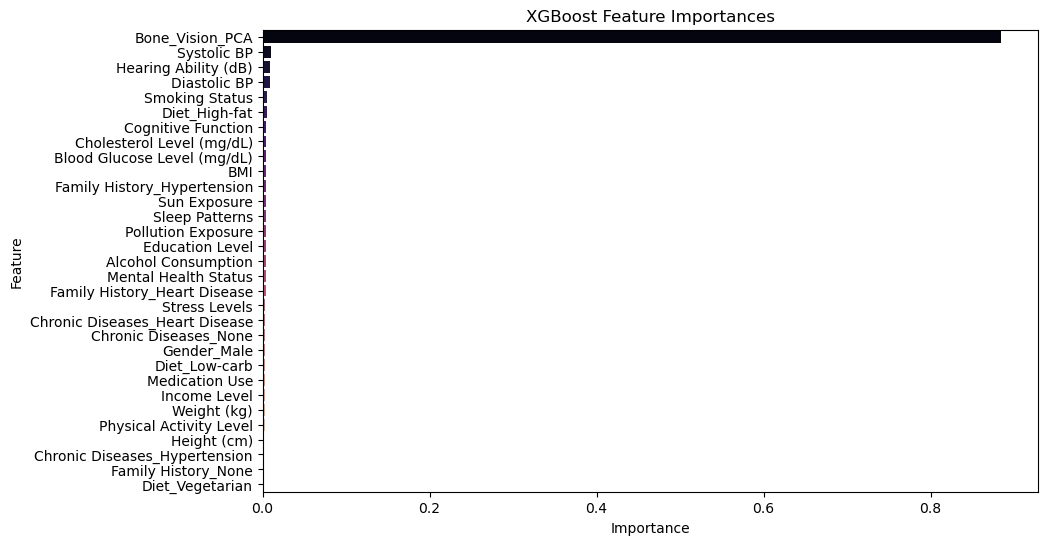

Variance Inflation Factor (VIF):
                           Feature         VIF
1                      Weight (kg)  102.184294
3                              BMI   91.010361
0                      Height (cm)   40.648898
23           Chronic Diseases_None    3.847315
30                 Bone_Vision_PCA    3.266975
20                     Gender_Male    2.594457
26             Family History_None    2.240693
9                   Medication Use    2.047110
5             Hearing Ability (dB)    1.906036
22   Chronic Diseases_Hypertension    1.788164
18                     Systolic BP    1.639589
21  Chronic Diseases_Heart Disease    1.626887
19                    Diastolic BP    1.532817
24    Family History_Heart Disease    1.485376
25     Family History_Hypertension    1.472199
10              Cognitive Function    1.339560
27                   Diet_High-fat    1.231251
2        Cholesterol Level (mg/dL)    1.222896
4      Blood Glucose Level (mg/dL)    1.216605
28                   Diet_L

In [9]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from statsmodels.stats.outliers_influence import variance_inflation_factor

# To suppress warnings
warnings.filterwarnings('ignore')

# ---------------------------
# 데이터 불러오기
# ---------------------------
train_df = pd.read_csv('Train.csv')

# ---------------------------
# 결측치 처리
# ---------------------------
columns_to_fill = ['Alcohol Consumption', 'Chronic Diseases', 'Medication Use', 'Family History']
train_df[columns_to_fill] = train_df[columns_to_fill].fillna('None')
train_df['Education Level'].fillna('Unknown', inplace=True)

# ---------------------------
# Blood Pressure (s/d) 분리
# ---------------------------
train_df[['Systolic BP', 'Diastolic BP']] = train_df['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
train_df.drop(columns=['Blood Pressure (s/d)'], inplace=True)

# ---------------------------
# 원-핫 인코딩
# ---------------------------
train_df = pd.get_dummies(train_df, columns=['Gender', 'Chronic Diseases', 'Family History', 'Diet'], drop_first=True)

# ---------------------------
# 사용자 정의 매핑을 적용한 레이블 인코딩
# ---------------------------
mapping_dict = {
    'Physical Activity Level': {'Low': 0, 'Moderate': 1, 'High': 2},
    'Smoking Status': {'Never': 0, 'Current': 1, 'Former': 2},
    'Alcohol Consumption': {'None': 0, 'Occasional': 1, 'Frequent': 2},
    'Medication Use': {'None': 0, 'Occasional': 1, 'Regular': 2},
    'Mental Health Status': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3},
    'Sleep Patterns': {'Insomnia': 0, 'Normal': 1, 'Excessive': 2},
    'Education Level': {'Unknown': 0, 'High School': 1, 'Undergraduate': 2, 'Postgraduate': 3},
    'Income Level': {'Low': 0, 'Medium': 1, 'High': 2}
}

train_df.replace(mapping_dict, inplace=True)

# ---------------------------
# Bone Density와 Vision Sharpness PCA 결합
# ---------------------------
bone_vision_data = train_df[['Bone Density (g/cm²)', 'Vision Sharpness']]
scaler = StandardScaler()
bone_vision_scaled = scaler.fit_transform(bone_vision_data)
pca = PCA(n_components=1)
train_df['Bone_Vision_PCA'] = pca.fit_transform(bone_vision_scaled)
train_df.drop(columns=['Bone Density (g/cm²)', 'Vision Sharpness'], inplace=True)

# ---------------------------
# Train 데이터에서 특성과 타겟 설정
# ---------------------------
X = train_df.drop(columns=['ID', 'Age (years)'])
y = train_df['Age (years)']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ---------------------------
# K-Fold 교차 검증 설정
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# ---------------------------
# 선형 회귀, XGBoost, 신경망 모델 학습 및 평가
# ---------------------------
models = {
    'Linear Regression': LinearRegression(),
    'XGBoost': XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100),
}

results = {'Model': [], 'R²': [], 'RMSE': []}

for name, model in models.items():
    r2_scores, rmse_scores = [], []
    for train_index, val_index in kf.split(X_scaled):
        X_train, X_val = X_scaled[train_index], X_scaled[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        
        r2_scores.append(r2_score(y_val, y_pred))
        rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    
    results['Model'].append(name)
    results['R²'].append(np.mean(r2_scores))
    results['RMSE'].append(np.mean(rmse_scores))

# ---------------------------
# 신경망 모델 학습 및 평가
# ---------------------------
nn_r2_scores, nn_rmse_scores = [], []

def build_nn():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X.shape[1],)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

for train_index, val_index in kf.split(X_scaled):
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y.iloc[train_index], y.iloc[val_index]

    nn_model = build_nn()
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    nn_model.fit(X_train, y_train, epochs=100, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    y_pred = nn_model.predict(X_val).flatten()

    nn_r2_scores.append(r2_score(y_val, y_pred))
    nn_rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

results['Model'].append('Neural Network')
results['R²'].append(np.mean(nn_r2_scores))
results['RMSE'].append(np.mean(nn_rmse_scores))

# ---------------------------
# 모델 성능 비교 시각화
# ---------------------------
results_df = pd.DataFrame(results)

# R² 비교
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='R²', data=results_df, palette='Blues')
plt.title('Model Performance: R² Scores')
plt.ylabel('R²')
plt.show()

# RMSE 비교
plt.figure(figsize=(10, 6))
sns.barplot(x='Model', y='RMSE', data=results_df, palette='Oranges')
plt.title('Model Performance: RMSE Scores')
plt.ylabel('RMSE')
plt.show()

# ---------------------------
# 추가 요구사항: 
# 1) 선형 회귀 모델의 회귀 계수(Coef.) 시각화
# 2) XGBoost 특성 중요도 시각화
# 3) VIF 표시
# ---------------------------

# 1) 선형 회귀 모델 회귀 계수 시각화
# 전체 데이터로 선형회귀 모델 학습 후 Coeff 시각화
lin_model = LinearRegression()
lin_model.fit(X_scaled, y)
coef = lin_model.coef_

# 회귀 계수를 DataFrame으로 변환
coef_df = pd.DataFrame({'Feature': X.columns, 'Coefficient': coef})
plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', orient='h', palette='viridis')
plt.title('Linear Regression Coefficients')
plt.show()

# 2) XGBoost 특성 중요도 시각화
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
xgb_model.fit(X_scaled, y)

# 특성 중요도 가져오기
xgb_importances = xgb_model.feature_importances_
xgb_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': xgb_importances})
xgb_importance_df = xgb_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=xgb_importance_df, x='Importance', y='Feature', orient='h', palette='magma')
plt.title('XGBoost Feature Importances')
plt.show()

# 3) VIF 표시
# VIF는 다중공선성을 측정하는 지표
# VIF를 계산하기 위해서는 데이터프레임 형태 필요
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

vif_data = pd.DataFrame()
vif_data["Feature"] = X_scaled_df.columns
vif_data["VIF"] = [variance_inflation_factor(X_scaled_df.values, i) for i in range(X_scaled_df.shape[1])]
vif_data = vif_data.sort_values("VIF", ascending=False)

print("Variance Inflation Factor (VIF):")
print(vif_data)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Linear Regression on Test Set (First 50 Data):
R²: 0.9360130097427001
RMSE: 5.225138407943767

XGBoost on Test Set (First 50 Data):
R²: 0.8977534174919128
RMSE: 6.605054087738655

Neural Network on Test Set (First 50 Data):
R²: 0.9111249446868896
RMSE: 6.158031844767602


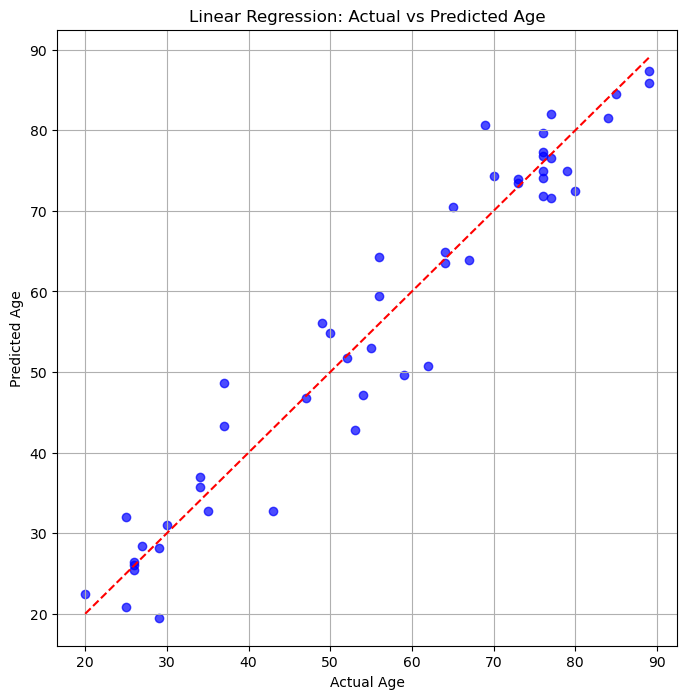

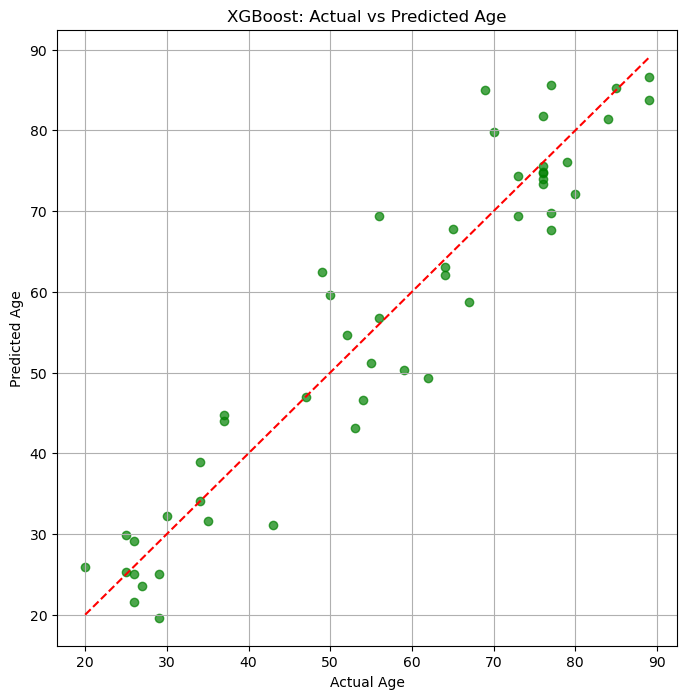

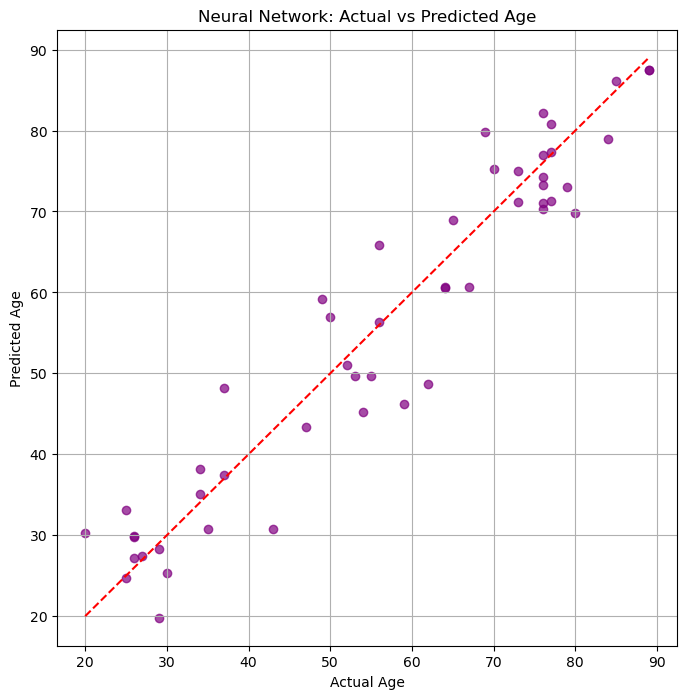

In [11]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ---------------------------
# 데이터 불러오기
# ---------------------------
df = pd.read_csv('Train.csv')

# ---------------------------
# 상위 50개 데이터를 별도의 테스트 셋으로 분리
# ---------------------------
test_df = df.iloc[:50].copy()
train_df = df.iloc[50:].copy()

# ---------------------------
# 결측치 처리
# ---------------------------
columns_to_fill = ['Alcohol Consumption', 'Chronic Diseases', 'Medication Use', 'Family History']
train_df[columns_to_fill] = train_df[columns_to_fill].fillna('None')
train_df['Education Level'].fillna('Unknown', inplace=True)

test_df[columns_to_fill] = test_df[columns_to_fill].fillna('None')
test_df['Education Level'].fillna('Unknown', inplace=True)

# ---------------------------
# Blood Pressure (s/d) 분리
# ---------------------------
train_df[['Systolic BP', 'Diastolic BP']] = train_df['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
train_df.drop(columns=['Blood Pressure (s/d)'], inplace=True)

test_df[['Systolic BP', 'Diastolic BP']] = test_df['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
test_df.drop(columns=['Blood Pressure (s/d)'], inplace=True)

# ---------------------------
# 원-핫 인코딩
# ---------------------------
train_df = pd.get_dummies(train_df, columns=['Gender', 'Chronic Diseases', 'Family History', 'Diet'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Gender', 'Chronic Diseases', 'Family History', 'Diet'], drop_first=True)

# train, test 간 칼럼 정렬 및 없는 칼럼 채우기
train_df, test_df = train_df.align(test_df, join='left', axis=1)
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# ---------------------------
# 사용자 정의 매핑을 적용한 레이블 인코딩
# ---------------------------
mapping_dict = {
    'Physical Activity Level': {'Low': 0, 'Moderate': 1, 'High': 2},
    'Smoking Status': {'Never': 0, 'Current': 1, 'Former': 2},
    'Alcohol Consumption': {'None': 0, 'Occasional': 1, 'Frequent': 2},
    'Medication Use': {'None': 0, 'Occasional': 1, 'Regular': 2},
    'Mental Health Status': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3},
    'Sleep Patterns': {'Insomnia': 0, 'Normal': 1, 'Excessive': 2},
    'Education Level': {'Unknown': 0, 'High School': 1, 'Undergraduate': 2, 'Postgraduate': 3},
    'Income Level': {'Low': 0, 'Medium': 1, 'High': 2}
}

train_df.replace(mapping_dict, inplace=True)
test_df.replace(mapping_dict, inplace=True)

# ---------------------------
# Bone Density와 Vision Sharpness PCA 결합
# ---------------------------
bone_vision_data_train = train_df[['Bone Density (g/cm²)', 'Vision Sharpness']]
bone_vision_data_test = test_df[['Bone Density (g/cm²)', 'Vision Sharpness']]

scaler_bv = StandardScaler()
bone_vision_scaled_train = scaler_bv.fit_transform(bone_vision_data_train)
bone_vision_scaled_test = scaler_bv.transform(bone_vision_data_test)

pca = PCA(n_components=1)
train_df['Bone_Vision_PCA'] = pca.fit_transform(bone_vision_scaled_train)
test_df['Bone_Vision_PCA'] = pca.transform(bone_vision_scaled_test)

train_df.drop(columns=['Bone Density (g/cm²)', 'Vision Sharpness'], inplace=True)
test_df.drop(columns=['Bone Density (g/cm²)', 'Vision Sharpness'], inplace=True)

# ---------------------------
# Train 데이터에서 특성과 타겟 설정
# ---------------------------
X_train = train_df.drop(columns=['ID', 'Age (years)'])
y_train = train_df['Age (years)']

X_test = test_df.drop(columns=['ID', 'Age (years)'])
y_test = test_df['Age (years)']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# K-Fold 교차 검증 설정
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def build_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 각 모델별로 최종 fold에서 학습된 모델을 저장할 변수
final_lin_model = None
final_xgb_model = None
final_nn_model = None

# ---------------------------
# 선형 회귀 모델
# ---------------------------
lin_r2_scores, lin_rmse_scores = [], []
for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    lin_model = LinearRegression()
    lin_model.fit(X_tr, y_tr)
    y_pred = lin_model.predict(X_val)
    
    lin_r2_scores.append(r2_score(y_val, y_pred))
    lin_rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))
    
# 마지막 fold 모델을 최종 모델로 사용
final_lin_model = lin_model

# ---------------------------
# XGBoost 모델
# ---------------------------
xgb_r2_scores, xgb_rmse_scores = [], []
for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
    xgb_model.fit(X_tr, y_tr)
    y_pred = xgb_model.predict(X_val)
    
    xgb_r2_scores.append(r2_score(y_val, y_pred))
    xgb_rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

# 마지막 fold 모델을 최종 모델로 사용
final_xgb_model = xgb_model

# ---------------------------
# 신경망 모델
# ---------------------------
nn_r2_scores, nn_rmse_scores = [], []
for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    nn_model = build_nn(X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    nn_model.fit(X_tr, y_tr, epochs=100, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    y_pred = nn_model.predict(X_val).flatten()

    nn_r2_scores.append(r2_score(y_val, y_pred))
    nn_rmse_scores.append(np.sqrt(mean_squared_error(y_val, y_pred)))

# 마지막 fold 모델을 최종 모델로 사용
final_nn_model = nn_model

# ---------------------------
# 각 모델을 테스트 세트에 적용하여 예측
# ---------------------------
y_test_pred_lin = final_lin_model.predict(X_test_scaled)
y_test_pred_xgb = final_xgb_model.predict(X_test_scaled)
y_test_pred_nn = final_nn_model.predict(X_test_scaled).flatten()

print("Linear Regression on Test Set (First 50 Data):")
print("R²:", r2_score(y_test, y_test_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_lin)))

print("\nXGBoost on Test Set (First 50 Data):")
print("R²:", r2_score(y_test, y_test_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)))

print("\nNeural Network on Test Set (First 50 Data):")
print("R²:", r2_score(y_test, y_test_pred_nn))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_nn)))

# ---------------------------
# 실제값 vs 예측값 비교 그래프 (각 모델별)
# ---------------------------
plt.figure(figsize=(8,8))
plt.scatter(y_test, y_test_pred_lin, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Linear Regression: Actual vs Predicted Age')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_test_pred_xgb, alpha=0.7, color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('XGBoost: Actual vs Predicted Age')
plt.grid(True)
plt.show()

plt.figure(figsize=(8,8))
plt.scatter(y_test, y_test_pred_nn, alpha=0.7, color='purple')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Neural Network: Actual vs Predicted Age')
plt.grid(True)
plt.show()


# 결과값 각자 비교

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Linear Regression on Test Set (First 50 Data):
R²: 0.9360130097427001
RMSE: 5.225138407943767

XGBoost on Test Set (First 50 Data):
R²: 0.8977534174919128
RMSE: 6.605054087738655

Neural Network on Test Set (First 50 Data):
R²: 0.9183201193809509
RMSE: 5.903498578909916


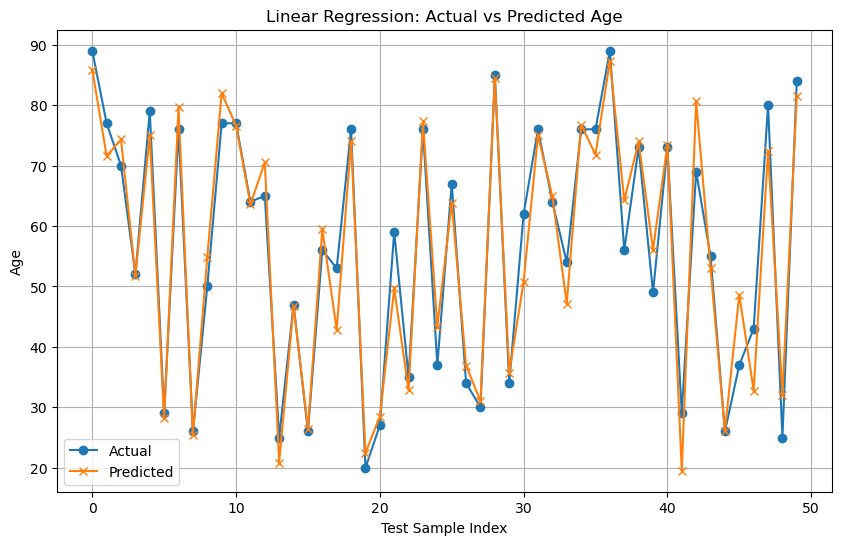

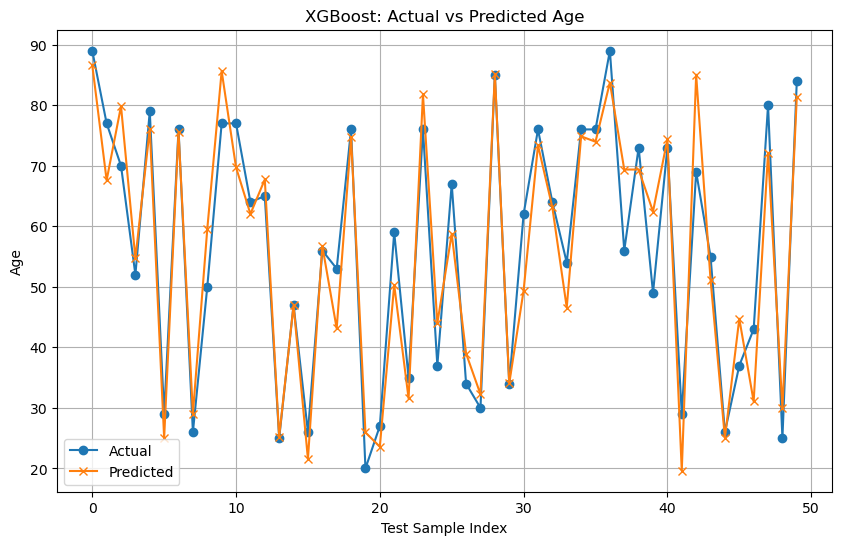

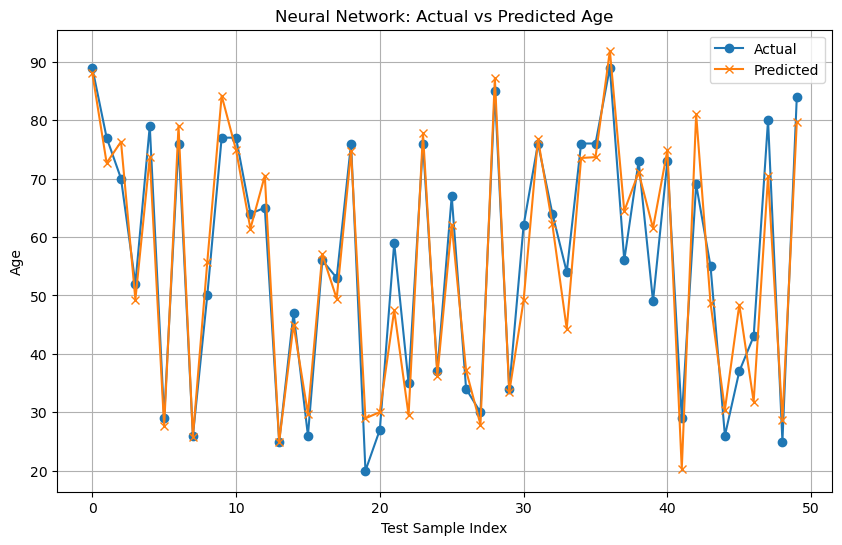

In [12]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ---------------------------
# 데이터 불러오기
# ---------------------------
df = pd.read_csv('Train.csv')

# ---------------------------
# 상위 50개 데이터를 별도의 테스트 셋으로 분리
# ---------------------------
test_df = df.iloc[:50].copy()
train_df = df.iloc[50:].copy()

# ---------------------------
# 결측치 처리
# ---------------------------
columns_to_fill = ['Alcohol Consumption', 'Chronic Diseases', 'Medication Use', 'Family History']
train_df[columns_to_fill] = train_df[columns_to_fill].fillna('None')
train_df['Education Level'].fillna('Unknown', inplace=True)

test_df[columns_to_fill] = test_df[columns_to_fill].fillna('None')
test_df['Education Level'].fillna('Unknown', inplace=True)

# ---------------------------
# Blood Pressure (s/d) 분리
# ---------------------------
train_df[['Systolic BP', 'Diastolic BP']] = train_df['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
train_df.drop(columns=['Blood Pressure (s/d)'], inplace=True)

test_df[['Systolic BP', 'Diastolic BP']] = test_df['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
test_df.drop(columns=['Blood Pressure (s/d)'], inplace=True)

# ---------------------------
# 원-핫 인코딩
# ---------------------------
train_df = pd.get_dummies(train_df, columns=['Gender', 'Chronic Diseases', 'Family History', 'Diet'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Gender', 'Chronic Diseases', 'Family History', 'Diet'], drop_first=True)

# train, test 간 칼럼 정렬 및 없는 칼럼 채우기
train_df, test_df = train_df.align(test_df, join='left', axis=1)
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# ---------------------------
# 사용자 정의 매핑을 적용한 레이블 인코딩
# ---------------------------
mapping_dict = {
    'Physical Activity Level': {'Low': 0, 'Moderate': 1, 'High': 2},
    'Smoking Status': {'Never': 0, 'Current': 1, 'Former': 2},
    'Alcohol Consumption': {'None': 0, 'Occasional': 1, 'Frequent': 2},
    'Medication Use': {'None': 0, 'Occasional': 1, 'Regular': 2},
    'Mental Health Status': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3},
    'Sleep Patterns': {'Insomnia': 0, 'Normal': 1, 'Excessive': 2},
    'Education Level': {'Unknown': 0, 'High School': 1, 'Undergraduate': 2, 'Postgraduate': 3},
    'Income Level': {'Low': 0, 'Medium': 1, 'High': 2}
}

train_df.replace(mapping_dict, inplace=True)
test_df.replace(mapping_dict, inplace=True)

# ---------------------------
# Bone Density와 Vision Sharpness PCA 결합
# ---------------------------
bone_vision_data_train = train_df[['Bone Density (g/cm²)', 'Vision Sharpness']]
bone_vision_data_test = test_df[['Bone Density (g/cm²)', 'Vision Sharpness']]

scaler_bv = StandardScaler()
bone_vision_scaled_train = scaler_bv.fit_transform(bone_vision_data_train)
bone_vision_scaled_test = scaler_bv.transform(bone_vision_data_test)

pca = PCA(n_components=1)
train_df['Bone_Vision_PCA'] = pca.fit_transform(bone_vision_scaled_train)
test_df['Bone_Vision_PCA'] = pca.transform(bone_vision_scaled_test)

train_df.drop(columns=['Bone Density (g/cm²)', 'Vision Sharpness'], inplace=True)
test_df.drop(columns=['Bone Density (g/cm²)', 'Vision Sharpness'], inplace=True)

# ---------------------------
# Train 데이터에서 특성과 타겟 설정
# ---------------------------
X_train = train_df.drop(columns=['ID', 'Age (years)'])
y_train = train_df['Age (years)']

X_test = test_df.drop(columns=['ID', 'Age (years)'])
y_test = test_df['Age (years)']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# K-Fold 교차 검증 설정
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def build_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 모델 최종 인스턴스를 저장할 변수
final_lin_model = None
final_xgb_model = None
final_nn_model = None

# ---------------------------
# 선형 회귀 모델
# ---------------------------
for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    lin_model = LinearRegression()
    lin_model.fit(X_tr, y_tr)
    # 마지막 fold 모델이 최종 모델이 됨
final_lin_model = lin_model

# ---------------------------
# XGBoost 모델
# ---------------------------
for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
    xgb_model.fit(X_tr, y_tr)
    # 마지막 fold 모델이 최종 모델이 됨
final_xgb_model = xgb_model

# ---------------------------
# 신경망 모델
# ---------------------------
for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]

    nn_model = build_nn(X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    nn_model.fit(X_tr, y_tr, epochs=100, verbose=0, validation_split=0.2, callbacks=[early_stopping])
    # 마지막 fold 모델이 최종 모델이 됨
final_nn_model = nn_model

# ---------------------------
# 각 모델을 테스트 세트에 적용하여 예측
# ---------------------------
y_test_pred_lin = final_lin_model.predict(X_test_scaled)
y_test_pred_xgb = final_xgb_model.predict(X_test_scaled)
y_test_pred_nn = final_nn_model.predict(X_test_scaled).flatten()

print("Linear Regression on Test Set (First 50 Data):")
print("R²:", r2_score(y_test, y_test_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_lin)))

print("\nXGBoost on Test Set (First 50 Data):")
print("R²:", r2_score(y_test, y_test_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)))

print("\nNeural Network on Test Set (First 50 Data):")
print("R²:", r2_score(y_test, y_test_pred_nn))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_nn)))

# ---------------------------
# 실제값 vs 예측값 비교 그래프 (순서 기반)
# ---------------------------
# Linear Regression 결과 비교
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_test_pred_lin, label='Predicted', marker='x')
plt.xlabel('Test Sample Index')
plt.ylabel('Age')
plt.title('Linear Regression: Actual vs Predicted Age')
plt.grid(True)
plt.legend()
plt.show()

# XGBoost 결과 비교
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_test_pred_xgb, label='Predicted', marker='x')
plt.xlabel('Test Sample Index')
plt.ylabel('Age')
plt.title('XGBoost: Actual vs Predicted Age')
plt.grid(True)
plt.legend()
plt.show()

# Neural Network 결과 비교
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_test_pred_nn, label='Predicted', marker='x')
plt.xlabel('Test Sample Index')
plt.ylabel('Age')
plt.title('Neural Network: Actual vs Predicted Age')
plt.grid(True)
plt.legend()
plt.show()


# 그래프 통합

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/stepWARNING:tensorflow:6 out of the last 25 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000001CAA4622520> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Linear Regression on Test Set (First 50 Data):
R²: 0.9360130097427001
RMSE: 5.225138407943767

XGBoost on Test Set (First 50 Data):
R²: 0.8977534174919128
RMSE: 6.605054087738655

Neural Network on 

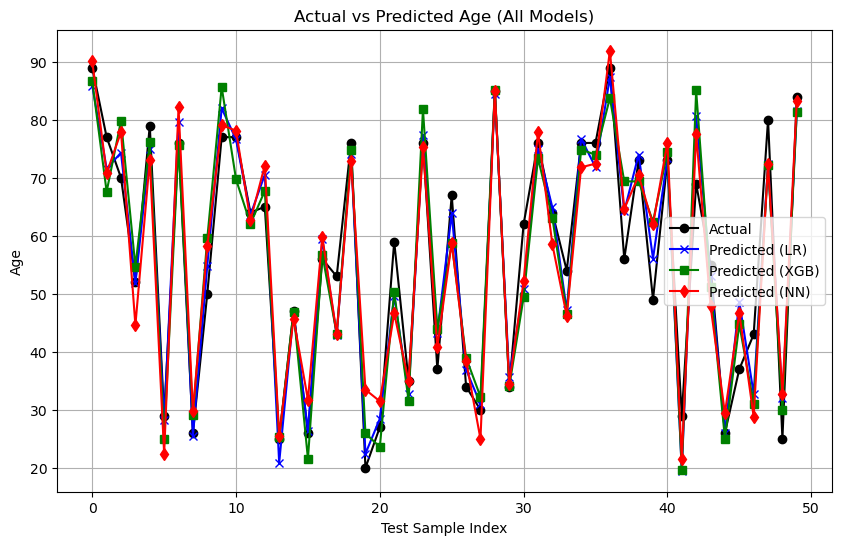

In [13]:
# 필요한 라이브러리 불러오기
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

# ---------------------------
# 데이터 불러오기
# ---------------------------
df = pd.read_csv('Train.csv')

# ---------------------------
# 상위 50개 데이터를 별도의 테스트 셋으로 분리
# ---------------------------
test_df = df.iloc[:50].copy()
train_df = df.iloc[50:].copy()

# ---------------------------
# 결측치 처리
# ---------------------------
columns_to_fill = ['Alcohol Consumption', 'Chronic Diseases', 'Medication Use', 'Family History']
train_df[columns_to_fill] = train_df[columns_to_fill].fillna('None')
train_df['Education Level'].fillna('Unknown', inplace=True)

test_df[columns_to_fill] = test_df[columns_to_fill].fillna('None')
test_df['Education Level'].fillna('Unknown', inplace=True)

# ---------------------------
# Blood Pressure (s/d) 분리
# ---------------------------
train_df[['Systolic BP', 'Diastolic BP']] = train_df['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
train_df.drop(columns=['Blood Pressure (s/d)'], inplace=True)

test_df[['Systolic BP', 'Diastolic BP']] = test_df['Blood Pressure (s/d)'].str.split('/', expand=True).astype(float)
test_df.drop(columns=['Blood Pressure (s/d)'], inplace=True)

# ---------------------------
# 원-핫 인코딩
# ---------------------------
train_df = pd.get_dummies(train_df, columns=['Gender', 'Chronic Diseases', 'Family History', 'Diet'], drop_first=True)
test_df = pd.get_dummies(test_df, columns=['Gender', 'Chronic Diseases', 'Family History', 'Diet'], drop_first=True)

# train, test 간 칼럼 정렬 및 없는 칼럼 채우기
train_df, test_df = train_df.align(test_df, join='left', axis=1)
train_df = train_df.fillna(0)
test_df = test_df.fillna(0)

# ---------------------------
# 사용자 정의 매핑을 적용한 레이블 인코딩
# ---------------------------
mapping_dict = {
    'Physical Activity Level': {'Low': 0, 'Moderate': 1, 'High': 2},
    'Smoking Status': {'Never': 0, 'Current': 1, 'Former': 2},
    'Alcohol Consumption': {'None': 0, 'Occasional': 1, 'Frequent': 2},
    'Medication Use': {'None': 0, 'Occasional': 1, 'Regular': 2},
    'Mental Health Status': {'Poor': 0, 'Fair': 1, 'Good': 2, 'Excellent': 3},
    'Sleep Patterns': {'Insomnia': 0, 'Normal': 1, 'Excessive': 2},
    'Education Level': {'Unknown': 0, 'High School': 1, 'Undergraduate': 2, 'Postgraduate': 3},
    'Income Level': {'Low': 0, 'Medium': 1, 'High': 2}
}

train_df.replace(mapping_dict, inplace=True)
test_df.replace(mapping_dict, inplace=True)

# ---------------------------
# Bone Density와 Vision Sharpness PCA 결합
# ---------------------------
bone_vision_data_train = train_df[['Bone Density (g/cm²)', 'Vision Sharpness']]
bone_vision_data_test = test_df[['Bone Density (g/cm²)', 'Vision Sharpness']]

scaler_bv = StandardScaler()
bone_vision_scaled_train = scaler_bv.fit_transform(bone_vision_data_train)
bone_vision_scaled_test = scaler_bv.transform(bone_vision_data_test)

pca = PCA(n_components=1)
train_df['Bone_Vision_PCA'] = pca.fit_transform(bone_vision_scaled_train)
test_df['Bone_Vision_PCA'] = pca.transform(bone_vision_scaled_test)

train_df.drop(columns=['Bone Density (g/cm²)', 'Vision Sharpness'], inplace=True)
test_df.drop(columns=['Bone Density (g/cm²)', 'Vision Sharpness'], inplace=True)

# ---------------------------
# Train 데이터에서 특성과 타겟 설정
# ---------------------------
X_train = train_df.drop(columns=['ID', 'Age (years)'])
y_train = train_df['Age (years)']

X_test = test_df.drop(columns=['ID', 'Age (years)'])
y_test = test_df['Age (years)']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------------------
# K-Fold 교차 검증 설정
# ---------------------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

def build_nn(input_dim):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)),
        Dense(32, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# 모델 최종 인스턴스를 저장할 변수
final_lin_model = None
final_xgb_model = None
final_nn_model = None

# 선형회귀
for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    lin_model = LinearRegression()
    lin_model.fit(X_tr, y_tr)
final_lin_model = lin_model

# XGBoost
for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)
    xgb_model.fit(X_tr, y_tr)
final_xgb_model = xgb_model

# 신경망
for train_index, val_index in kf.split(X_train_scaled):
    X_tr, X_val = X_train_scaled[train_index], X_train_scaled[val_index]
    y_tr, y_val = y_train.iloc[train_index], y_train.iloc[val_index]
    nn_model = build_nn(X_train.shape[1])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    nn_model.fit(X_tr, y_tr, epochs=100, verbose=0, validation_split=0.2, callbacks=[early_stopping])
final_nn_model = nn_model

# 테스트 세트 예측
y_test_pred_lin = final_lin_model.predict(X_test_scaled)
y_test_pred_xgb = final_xgb_model.predict(X_test_scaled)
y_test_pred_nn = final_nn_model.predict(X_test_scaled).flatten()

print("Linear Regression on Test Set (First 50 Data):")
print("R²:", r2_score(y_test, y_test_pred_lin))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_lin)))

print("\nXGBoost on Test Set (First 50 Data):")
print("R²:", r2_score(y_test, y_test_pred_xgb))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_xgb)))

print("\nNeural Network on Test Set (First 50 Data):")
print("R²:", r2_score(y_test, y_test_pred_nn))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_test_pred_nn)))

# ---------------------------
# 실제값 vs 예측값 비교 그래프 (하나의 그래프에 모두 표시)
# ---------------------------
plt.figure(figsize=(10,6))
plt.plot(y_test.values, label='Actual', marker='o', color='black')
plt.plot(y_test_pred_lin, label='Predicted (LR)', marker='x', color='blue')
plt.plot(y_test_pred_xgb, label='Predicted (XGB)', marker='s', color='green')
plt.plot(y_test_pred_nn, label='Predicted (NN)', marker='d', color='red')

plt.xlabel('Test Sample Index')
plt.ylabel('Age')
plt.title('Actual vs Predicted Age (All Models)')
plt.grid(True)
plt.legend()
plt.show()
